This project delves into the application of physics-informed neural networks (PINNs) for solving complex partial differential equations, specifically focusing on Burger's Equation as a case study. We explore the integration of physics-based principles into the neural network's loss function, aiming to enhance prediction accuracy and model efficiency. The project comprehensively evaluates the performance of these PINNs through extensive training, fine-tuning of learning rates, and a detailed comparison of model predictions against known solutions across various time and spatial dimensions.

In [ ]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.14.0'

In [ ]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [ ]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

(100,) (256,) (256, 100)


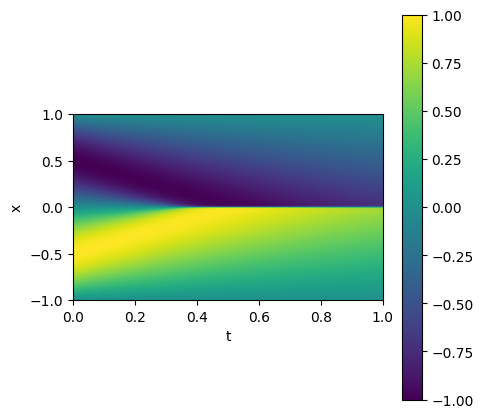

In [ ]:
data = scipy.io.loadmat('burgers_shock.mat')

data.keys()

t = data['t'].flatten() #time
x = data['x'].flatten() #position
Z = np.real(data['usol']) #solution of Burger's Ee

print(t.shape, x.shape, Z.shape)

ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar(cb);


## Figure 1: This plot visualizes the solution of Burger's Equation over a range of time (t) and position (x). The color intensity represents the magnitude of the solution, with the colorbar indicating the scale, and the axes labeled to show the temporal and spatial dimensions of the data.

# PROBLEM SETUP: BURGER'S EQUATIONS
$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$


$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$


# SPECIFIC CASE: LIMIT REGIME AND SET VISCOSITY TO $\nu=0.01/\pi$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),&&\mathrm{eq.1}\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],&\mathrm{eq.2}\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [ ]:
tf.random.set_seed(123)
pi = tf.constant(np.pi, dtype="float32")

In [ ]:
def fun_u_0(x): #u(0,x) eq 2
  return -tf.sin(pi * x)

def fun_u_b(t, x): #u(t,x) - set up container
  return tf.zeros((x.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx): #deruvatuve equation eq 1 - u_. is the derivative w respect to .
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

In [ ]:
#number of points we are using for training and predicting
n_0 = 50 #points at t=0 -> initial conditions
n_b = 50 #points at b=1;-1] -> boundary conditions
n_r = 10000

#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# get random data in x at t=0


In [ ]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        , -0.7476938 ],
       [ 0.        ,  0.14550257],
       [ 0.        , -0.4013734 ],
       [ 0.        ,  0.09236717],
       [ 0.        ,  0.44103146],
       [ 0.        ,  0.5779066 ],
       [ 0.        , -0.3846376 ],
       [ 0.        , -0.03657794],
       [ 0.        ,  0.30755043],
       [ 0.        , -0.7580149 ],
       [ 0.        , -0.27416515],
       [ 0.        , -0.5102    ],
       [ 0.        , -0.54608774],
       [ 0.        ,  0.04020071],
       [ 0.        ,  0.7369325 ],
       [ 0.        , -0.42762113],
       [ 0.        , -0.01630592],
       [ 0.        ,  0.34997678],
       [ 0.        , -0.11965895],
       [ 0.        , -0.02140164],
       [ 0.        ,  0.6112704 ],
       [ 0.        ,  0.7948568 ],
       [ 0.        ,  0.27323198],
       [ 0.        ,  0.00240111],
       [ 0.        , -0.03221846],
       [ 0.        ,  0.50451255],
       [ 0.        ,  0.6129718 ],
      

# evaluate initial condition at x_0

In [ ]:
u_0 = fun_u_0(x_0) #eq 2
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[ 0.7122112 ],
       [-0.44135648],
       [ 0.95238096],
       [-0.28612474],
       [-0.9828893 ],
       [-0.97019774],
       [ 0.93504095],
       [ 0.11466026],
       [-0.8227306 ],
       [ 0.6890799 ],
       [ 0.7587001 ],
       [ 0.9994866 ],
       [ 0.9895364 ],
       [-0.12595879],
       [-0.7355314 ],
       [ 0.97425926],
       [ 0.05120417],
       [-0.89097345],
       [ 0.36712813],
       [ 0.0671846 ],
       [-0.9395213 ],
       [-0.60077995],
       [-0.756787  ],
       [-0.00754325],
       [ 0.10104453],
       [-0.9998995 ],
       [-0.9376773 ],
       [ 0.06082507],
       [ 0.49481562],
       [-0.48312566],
       [ 0.94241977],
       [-0.5245297 ],
       [-0.8038826 ],
       [ 0.8135314 ],
       [-0.8391674 ],
       [-0.85155034],
       [-0.9423501 ],
       [ 0.77795136],
       [ 0.5914944 ],
       [ 0.09085801],
       [ 0.49529788],
       [ 0.4755419 ],
       [ 0.01998235],
     

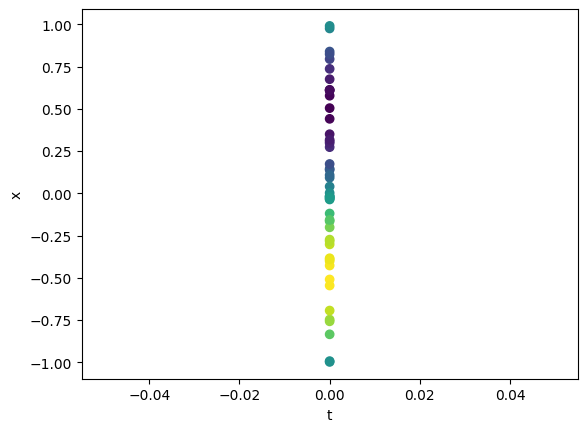

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

## Figure 2: This scatter plot displays data points at an initial time (t = 0), with their positions (x) and corresponding values (u). Each point's color intensity represents its value, with the color scale ranging from -1 to 1, and the axes are labeled to denote the temporal and spatial coordinates.

# get data at boundaries of x at random t's



In [ ]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.88968754,  1.        ],
       [ 0.12354946,  1.        ],
       [ 0.7718717 , -1.        ],
       [ 0.6850728 , -1.        ],
       [ 0.6442598 , -1.        ],
       [ 0.07745004,  1.        ],
       [ 0.75058556,  1.        ],
       [ 0.6250843 , -1.        ],
       [ 0.00772953,  1.        ],
       [ 0.55370283, -1.        ],
       [ 0.83894694,  1.        ],
       [ 0.43658102, -1.        ],
       [ 0.9566101 ,  1.        ],
       [ 0.7588576 ,  1.        ],
       [ 0.8964343 ,  1.        ],
       [ 0.44467843, -1.        ],
       [ 0.3243779 , -1.        ],
       [ 0.3443855 ,  1.        ],
       [ 0.91262174, -1.        ],
       [ 0.77731085,  1.        ],
       [ 0.899588  ,  1.        ],
       [ 0.50426483, -1.        ],
       [ 0.45032525, -1.        ],
       [ 0.5939442 ,  1.        ],
       [ 0.71862614,  1.        ],
       [ 0.91657436, -1.        ],
       [ 0.98180914, -1.        ],
      

# evaluate data at boundaries of x at random t's


In [ ]:
u_b = fun_u_b(t_b, x_b)
u_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

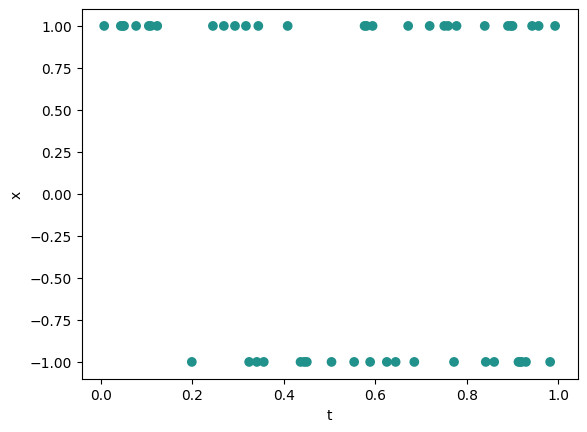

In [ ]:
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

## Figure 3: This plot illustrates the boundary of x at random times (t), generated for a neural network training process. The data points, represented by combinations of t_b and x_b, are spread across the specified range, showing the diversity in the time-space domain used for training the neural network model.

# get points inside the space at random where the function will be predicted

In [ ]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.48962688, -0.15719008],
       [ 0.5857923 ,  0.16138387],
       [ 0.36451697, -0.43461084],
       ...,
       [ 0.9338294 ,  0.9995079 ],
       [ 0.11166203, -0.28287673],
       [ 0.00506091,  0.7726338 ]], dtype=float32)>

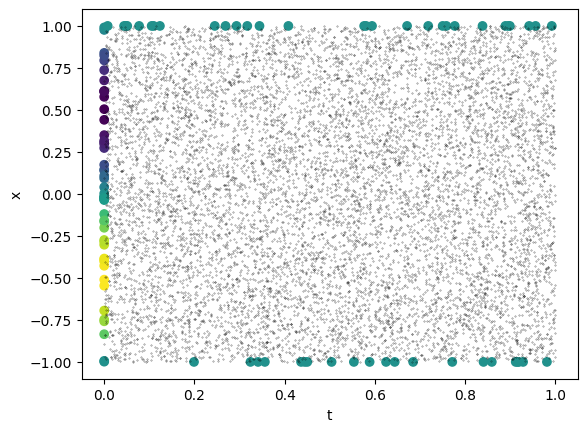

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c="k", marker='.', s=0.3, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

## Figure 4: This plot presents a comprehensive view of the data points that will be predicted by a neural network. It includes initial conditions (t_0, x_0, u_0) and boundary conditions (t_b, x_b, u_b) shown with colored markers, and the black dots (t_r, x_r) represent additional points in the time-space domain where the neural network predictions will occur. The color intensity of the markers corresponds to the values ranging from -1 to 1, with the plot axes labeled to indicate time (t) and position (x).

In [ ]:
#put boundary conditionns together
X = tf.concat([X_0, X_b], axis=0)
y = tf.concat([u_0, u_b], axis=0)
X.shape, y.shape


(TensorShape([100, 2]), TensorShape([100, 1]))

# create the model with simple loss

In [ ]:
nnmodel = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
nnmodel.add(tf.keras.Input(2))

#hidden layers
for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(20, activation="tanh"))

#output layer is 1D
nnmodel.add(tf.keras.layers.Dense(1))


In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss(u_pred, u_data):
  return tf.reduce_mean(tf.square(u_data - u_pred)) #L2

In [ ]:
nnmodel.compile(loss=custom_loss, optimizer=optim)

## train the model

In [ ]:
history = nnmodel.fit(X, y, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 6s 11ms/step - loss: 0.2159
Epoch 2/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1899
Epoch 3/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1947
Epoch 4/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1847
Epoch 5/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.1807
Epoch 6/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.1806
Epoch 7/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1757
Epoch 8/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.1716
Epoch 9/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.1701
Epoch 10/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1637
Epoch 11/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1503
Epoch 12/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1402
Epoch 13/1000
4/4 [==========================

Text(0, 0.5, 'loss')

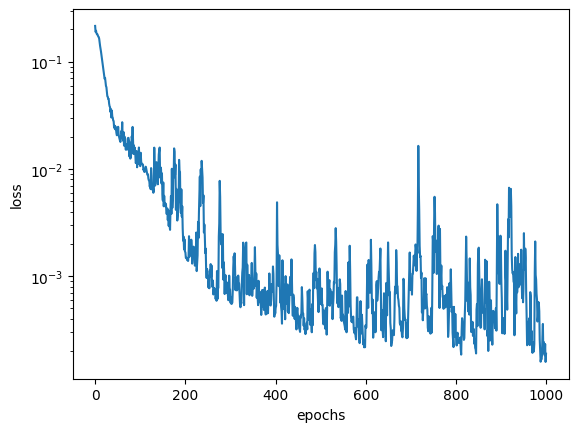

In [ ]:
pl.semilogy(history.history["loss"])
pl.xlabel("epochs")
pl.ylabel("loss")

## Figure 5: This plot is a semi-logarithmic graph showing the loss of a neural network model during training over various epochs. The y-axis represents the loss on a logarithmic scale, emphasizing the rate of decrease in loss, while the x-axis shows the number of epochs, indicating the progression of the training process.

## see the result

In [ ]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

313/313 [==============================] - 1s 2ms/step


array([[-0.01851278],
       [-0.01576739],
       [-0.01596152],
       ...,
       [-0.00306904],
       [-0.07790136],
       [-0.5563267 ]], dtype=float32)

313/313 [==============================] - 1s 2ms/step


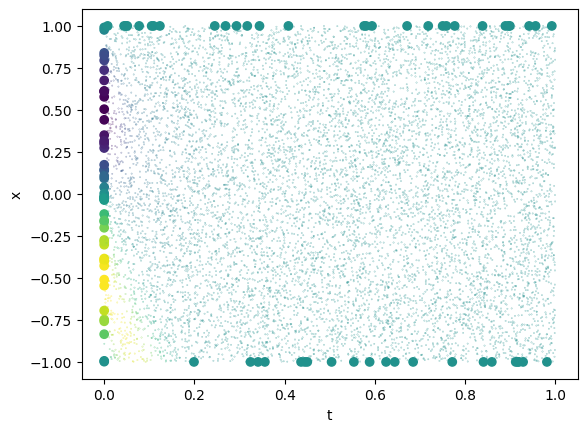

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=nnmodel.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

## Figure 6: This plot illustrates a comprehensive visualization of data points involved in training and predicting with a neural network model. It includes initial conditions (t_0, x_0, u_0) and boundary conditions (t_b, x_b, u_b), both represented with colored markers. Additionally, it shows predictions made by the neural network, indicated by the smaller, semi-transparent dots, for various points in the time-space domain (t_r, x_r). The color intensity of each point corresponds to its value, ranging from -1 to 1, with the axes labeled to denote the temporal (t) and spatial (x) dimensions. This visualization effectively demonstrates the areas where the neural network has made its predictions based on the training data.

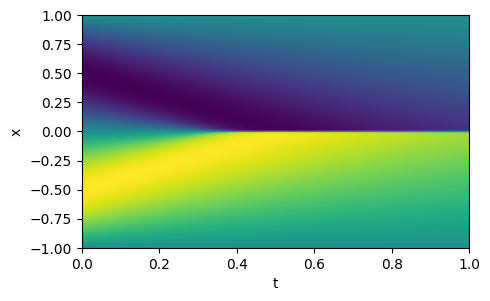

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);


## Figure 7: This figure features a heat map visualizing the solution data (Z) across two dimensions: time (t) and position (x). The data is presented as an image, with the color intensity indicating the solution's magnitude, bounded by a range of -1 to 1. The axes are clearly labeled to represent time on the x-axis and position on the y-axis.

show the accuracy for every point that you solved for

8/8 [==============================] - 0s 2ms/step


-3.784865324418227

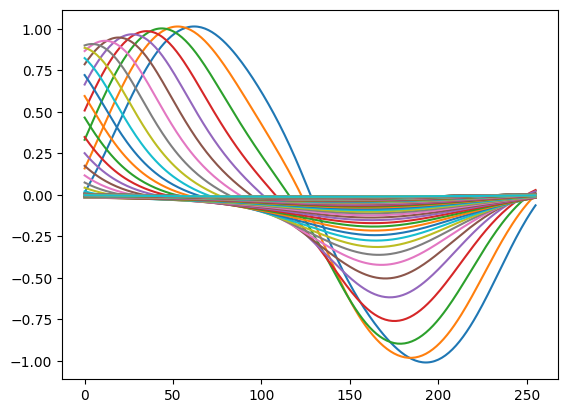

In [ ]:
def L1accuracy(t, x, model):
  tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
  tmp_[:,1] += x
  acc = 0
  for tt in range(t.shape[0]):
    tmp_[:,0] = t[tt]
    pl.plot(model.predict(tmp_))
    acc += (model.predict(tmp_) - Z[:,tt]).sum()


  return acc / np.prod(t.shape[0] * x.shape[0])
L1accuracy(t, x, nnmodel)

8/8 [==============================] - 0s 2ms/step


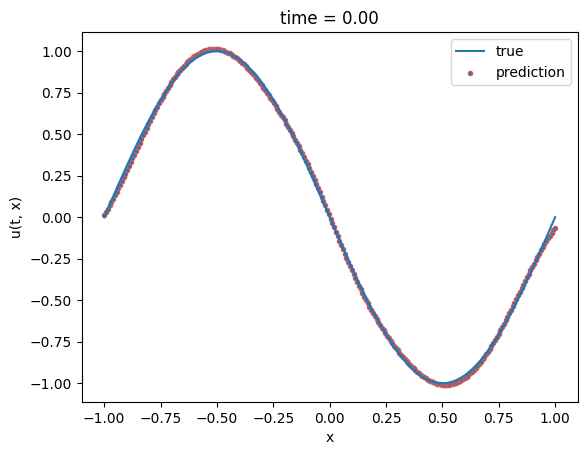

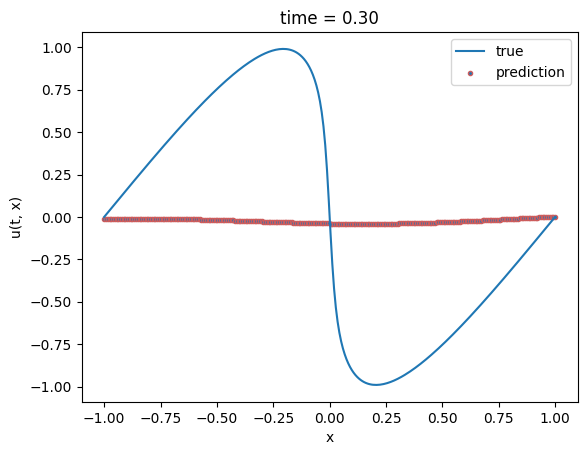

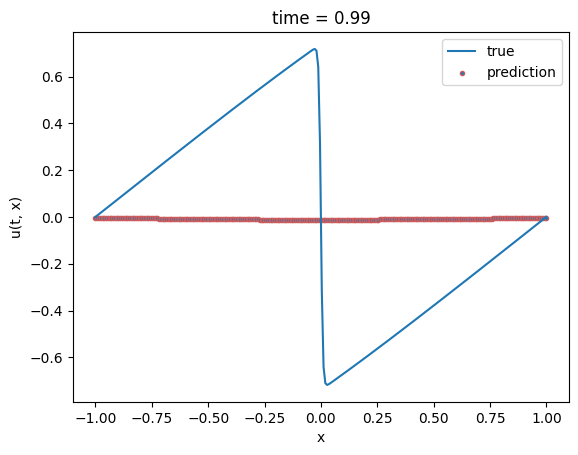

In [ ]:
tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
tmp_[:,1] += x
inds = [0, 30, -1]
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, nnmodel.predict(tmp_), marker='.', edgecolors="IndianRed",
             label="prediction")
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();


## Figure 8:
This series of three plots represents the true solution and neural network predictions for Burger's Equation at specific time instances. For each plot:
The title indicates the time instance (e.g., "time = [value]") chosen from the t array at indices 0, 30, and the last index.
The true solution at this time instance is plotted as a line graph with x on the x-axis and corresponding Z[:,inds[i]] (solution values) on the y-axis.
Predictions from the neural network (nnmodel) are scattered over the same x values. The tmp_ array is used to feed the current time and position data to the neural network for predictions.
Each plot has markers colored in "IndianRed" for the predictions and includes labels for clarity.
The x-axis is labeled "x" and the y-axis is labeled "u(t, x)", representing the solution of the equation at given time and position.
A legend is included in each plot to differentiate between the true solution and the neural network predictions.
Overall, these plots aim to visually compare the accuracy of the neural network's predictions against the true solutions at different time instances.

# create the model with complete loss

In [ ]:
def get_pde(model, X_r):

  with tf.GradientTape(persistent=True) as tape:
      t, x = X_r[:,0:1], X_r[:,1:2]
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1))
      u_x = tape.gradient(u,x)
      #print(u_x)
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape # to save some memory

  return u, u_t, u_x, u_xx


In [ ]:
def custom_loss(model, X_r, X, y):
  u_pred = model(X)
  loss = tf.reduce_mean(tf.square(y - u_pred))
  # PDE
  u_pred, u_t, u_x, u_xx = get_pde(model, X_r)
  resids = fun_res(u_pred, u_t, u_x, u_xx) #PDE
  loss += tf.reduce_mean(tf.square(resids)) #MSPDE
  return loss


In [ ]:
def get_grad(model, X_r, X, y):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = custom_loss(model, X_r, X, y)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

## train the model

In [ ]:
import copy

In [ ]:
pinn = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
pinn.add(tf.keras.Input(2))

#hidden layers
for i in range(8):
  pinn.add(tf.keras.layers.Dense(20, activation="tanh"))

#output layer is 1D
pinn.add(tf.keras.layers.Dense(1))

In [ ]:
@tf.function
def train_step(model, X_r, X, y):

  loss, grad = get_grad(model, X_r, X, y)
  optim.apply_gradients(zip(grad, model.trainable_variables))
  return loss

optim = tf.keras.optimizers.Adam(learning_rate=0.005)
pinn.compile(loss=custom_loss, optimizer=optim) #change the loss and optimization

history = []
Nepochs = 5000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))



It 00000: loss = 6.67218089e-01
It 00050: loss = 9.91473198e-02
It 00100: loss = 8.38331729e-02
It 00150: loss = 7.47729987e-02
It 00200: loss = 6.23147488e-02
It 00250: loss = 5.79034612e-02
It 00300: loss = 5.61400279e-02
It 00350: loss = 7.00328201e-02
It 00400: loss = 3.77167240e-02
It 00450: loss = 4.66672294e-02
It 00500: loss = 1.95162036e-02
It 00550: loss = 1.54563021e-02
It 00600: loss = 2.64811665e-02
It 00650: loss = 1.32285394e-02
It 00700: loss = 9.18220170e-03
It 00750: loss = 1.10020377e-02
It 00800: loss = 4.64886706e-03
It 00850: loss = 6.72980677e-03
It 00900: loss = 1.30156465e-02
It 00950: loss = 3.27090570e-03
It 01000: loss = 5.12194820e-03
It 01050: loss = 2.32299231e-03
It 01100: loss = 2.85152020e-03
It 01150: loss = 1.55371819e-02
It 01200: loss = 2.06957757e-03
It 01250: loss = 7.26287859e-03
It 01300: loss = 1.44635839e-03
It 01350: loss = 1.34859793e-03
It 01400: loss = 1.85190910e-03
It 01450: loss = 1.27133890e-03
It 01500: loss = 1.61033031e-03
It 01550

313/313 [==============================] - 1s 2ms/step


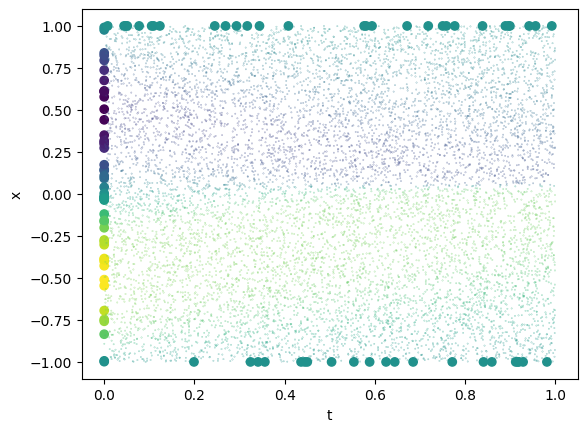

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

## Figure 9: This plot displays a comprehensive comparison of initial and boundary conditions, alongside predictions from a physics-informed neural network (PINN). Initial and boundary conditions are shown with colored markers, while PINN predictions are visualized as smaller, semi-transparent dots, effectively showcasing the model's performance across different time (t) and spatial (x) coordinates. The color intensity of each marker represents the value range from -1 to 1, providing a clear depiction of the model's output in relation to the actual data.

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
ax.set_aspect(0.3);

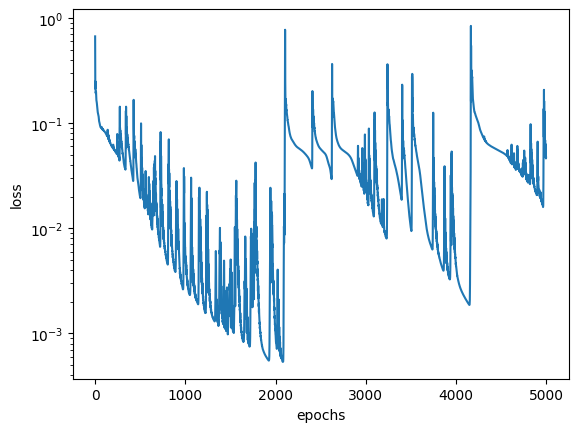

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss");

## Figure 10: This plot shows the initial training phase of a neural network using a physics-informed loss function. The logarithmic scale on the y-axis highlights the decrease in loss, illustrating the network's learning progress over the number of epochs, as indicated on the x-axis. This visualization is key for understanding the initial phase of the network's training dynamics.

8/8 [==============================] - 0s 3ms/step


13.97668839701435

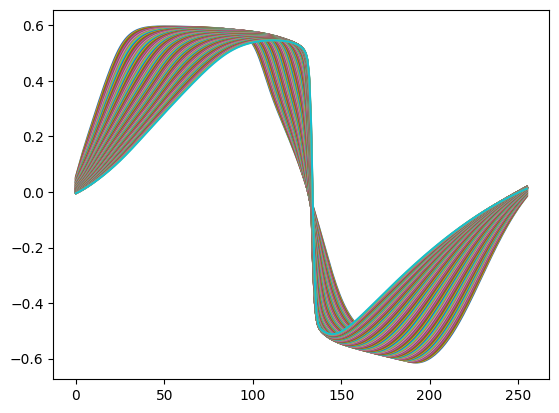

In [ ]:
L1accuracy(t, x, pinn)

## Figure 10.5: This plot illustrates the predictions made by a neural network model at different time instances across a specified range. For each time instance, the model's output is plotted as a line graph, depicting how the predicted values change across varying positions (x). The accumulation of these plots over the entire time range provides a comprehensive view of the model's performance in predicting the solution over time and space.

# adjust the learning rate and trin some more
the loss was awfully noisy

In [ ]:
from tensorflow.keras.backend import set_value
set_value(pinn.optimizer.lr, 0.0001)

In [ ]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))


It 00000: loss = 4.31298018e-02
It 00050: loss = 3.65863368e-02
It 00100: loss = 3.48191783e-02
It 00150: loss = 3.32545266e-02
It 00200: loss = 3.18467095e-02
It 00250: loss = 3.05337459e-02
It 00300: loss = 2.91558579e-02
It 00350: loss = 2.75400095e-02
It 00400: loss = 2.63833702e-02
It 00450: loss = 2.53595151e-02
It 00500: loss = 2.44300142e-02
It 00550: loss = 2.35824361e-02
It 00600: loss = 2.28056610e-02
It 00650: loss = 2.20900625e-02
It 00700: loss = 2.14278717e-02
It 00750: loss = 2.08132416e-02
It 00800: loss = 2.02418305e-02
It 00850: loss = 1.97103843e-02
It 00900: loss = 1.92161873e-02
It 00950: loss = 1.87567901e-02
It 01000: loss = 1.83297321e-02
It 01050: loss = 1.79325417e-02
It 01100: loss = 1.75626278e-02
It 01150: loss = 1.72173623e-02
It 01200: loss = 1.68941077e-02
It 01250: loss = 1.65902693e-02
It 01300: loss = 1.63033567e-02
It 01350: loss = 1.60310362e-02
It 01400: loss = 1.57711208e-02
It 01450: loss = 1.55215729e-02
It 01500: loss = 1.52803976e-02
It 01550

Text(0, 0.5, 'loss')

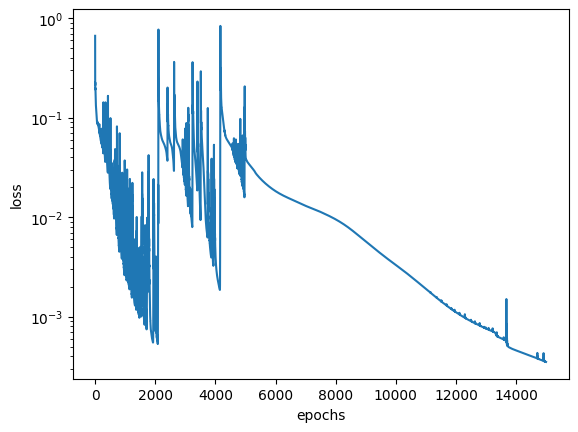

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

## Figure 11: This plot depicts the continued training of the neural network, with a fixed learning rate implemented. The semi-logarithmic graph again emphasizes the reduction in loss over successive epochs, allowing for an assessment of the network's improved learning efficiency and stability with the adjusted learning rate.

313/313 [==============================] - 1s 2ms/step


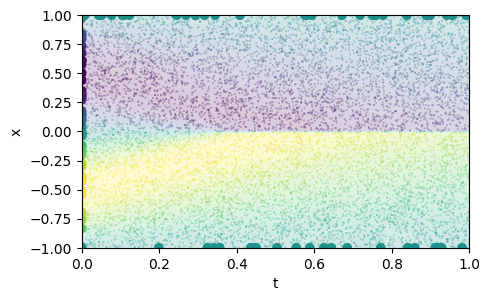

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot()
ax.imshow(Z[::-1],extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);

## Figure 12: This figure presents a layered visualization combining a heatmap and scatter plots to showcase the performance of a physics-informed neural network (PINN) in predicting data. The heatmap in the background, with reduced opacity, represents the solution data (Z) across time (t) and position (x), providing a contextual reference. Overlaid on this are three sets of scatter points: initial conditions (t_0, x_0, u_0), boundary conditions (t_b, x_b, u_b), and PINN predictions (t_r, x_r) with varying opacities and markers, representing different aspects of the data. The varied color intensities indicate the range of values. The axes are labeled to denote the temporal and spatial dimensions, and the aspect ratio is set to 0.3 for proportional representation of the data dimensions. This composite plot effectively illustrates the improved predictions of the PINN against the backdrop of the original solution data.

In [ ]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 3.51890456e-04
It 00050: loss = 3.47192428e-04
It 00100: loss = 3.42491578e-04
It 00150: loss = 3.84763291e-04
It 00200: loss = 3.33534437e-04
It 00250: loss = 3.28874245e-04
It 00300: loss = 3.24415741e-04
It 00350: loss = 3.20343912e-04
It 00400: loss = 3.15884681e-04
It 00450: loss = 3.11641081e-04
It 00500: loss = 3.07437323e-04
It 00550: loss = 3.08058719e-04
It 00600: loss = 2.99394102e-04
It 00650: loss = 2.95445585e-04
It 00700: loss = 2.91521195e-04
It 00750: loss = 2.87917326e-04
It 00800: loss = 2.84087437e-04
It 00850: loss = 2.80284614e-04
It 00900: loss = 2.76674895e-04
It 00950: loss = 2.81930203e-04
It 01000: loss = 2.69735610e-04
It 01050: loss = 2.66327523e-04
It 01100: loss = 2.62921967e-04
It 01150: loss = 2.60861445e-04
It 01200: loss = 2.56600790e-04
It 01250: loss = 2.53502425e-04
It 01300: loss = 2.50448298e-04
It 01350: loss = 2.47752818e-04
It 01400: loss = 2.44705094e-04
It 01450: loss = 2.41876260e-04
It 01500: loss = 2.39045112e-04
It 01550

Text(0, 0.5, 'loss')

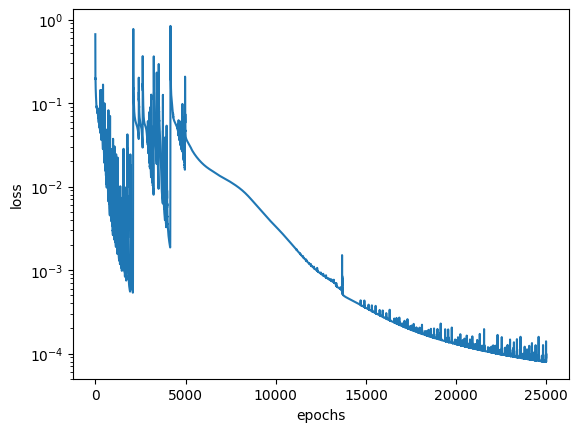

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

## Figure 13: This plot displays the continued training progress of a neural network, with a focus on loss reduction over additional epochs. The semi-logarithmic y-axis emphasizes the decrease in loss values, highlighting the network's ongoing learning and optimization. The x-axis represents the increasing number of epochs, showcasing the extended duration of the training. This visualization is crucial for understanding the network's performance and learning stability over a prolonged training period.

## final result

8/8 [==============================] - 0s 2ms/step


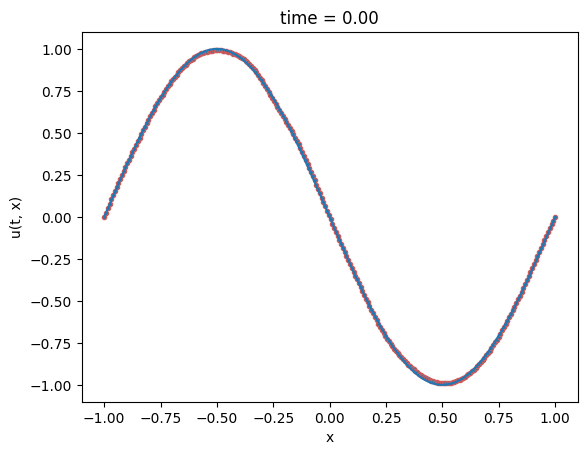

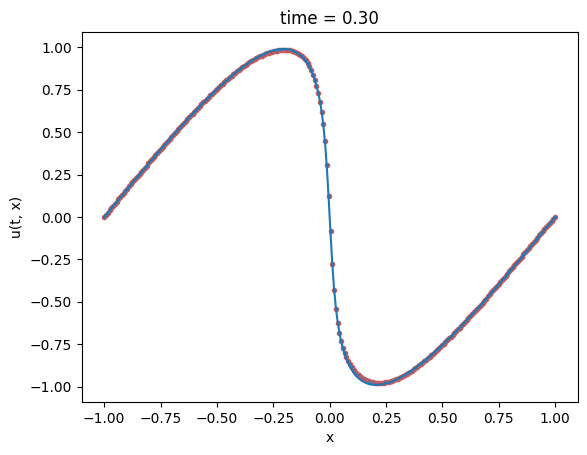

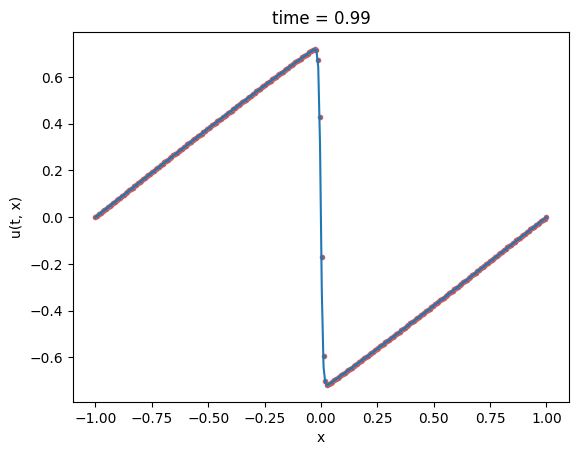

In [ ]:
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]])
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, pinn.predict(tmp_), marker='.', edgecolors="IndianRed")
  pl.xlabel("x")
  pl.ylabel("u(t, x)");

## Figure 13:

This series of three plots showcases the final results of a physics-informed neural network (PINN) model at specific time instances. For each plot:

The title indicates the specific time instance, with the value taken from the t array at predetermined indices (e.g., "time = [value]").

A line graph plots the true solution (Z[:,inds[i]]) against position (x), depicting how the solution behaves spatially at that time.

Superimposed on this line graph are scatter plots, where each dot represents a PINN prediction for the corresponding position x. The tmp_ array, updated with the current time t[inds[i]], is used for these predictions.

The scatter plots use a distinct marker style and edge color ("IndianRed") to differentiate the PINN predictions from the true solution.

The x-axis is labeled "x", and the y-axis is labeled "u(t, x)", representing the solution of the equation at the given time and position.

Overall, these plots provide a clear comparison between the actual solution of the equation and the predictions made by the PINN at different time points, illustrating the model's accuracy and effectiveness.

313/313 [==============================] - 1s 2ms/step


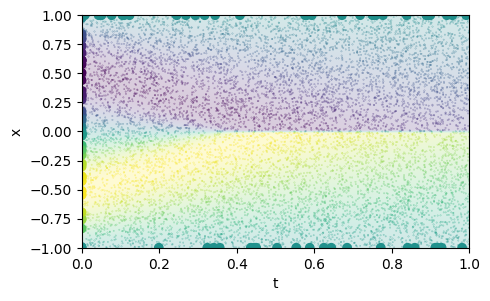

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.imshow(Z[::-1], extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
#pl.colorbar();

## Figure 14: This figure overlays a heatmap and scatter plots to demonstrate a physics-informed neural network's (PINN) predictions against solution data (Z). It shows initial and boundary conditions with colored markers, alongside PINN predictions as semi-transparent dots, against a faint backdrop of the solution across time (t) and position (x). The plot, with axes labeled for time and position and an aspect ratio of 0.3, provides a clear, concise visualization of the model's predictive accuracy.

8/8 [==============================] - 0s 4ms/step


0.5254379272645555

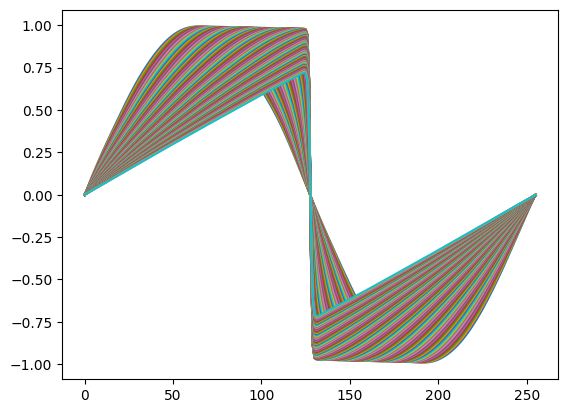

In [ ]:
L1accuracy(t, x, pinn)

## Figure 15: This plot illustrates the predictions made by a neural network model at different time instances across a specified range. For each time instance, the model's output is plotted as a line graph, depicting how the predicted values change across varying positions (x). The accumulation of these plots over the entire time range provides a comprehensive view of the model's performance in predicting the solution over time and space.

#Conclusion
In this work, the implementation of a physics-informed loss function significantly enhanced the performance of a neural network in solving complex equations, like Burger's Equation. The use of this specialized loss function led to more accurate predictions, as evidenced by a comparison between the network's output and the true solution across various time and spatial dimensions. Continued training with a fine-tuned learning rate further improved the model's accuracy, underscoring the effectiveness of tailored learning strategies in neural network training. Overall, the integration of physical principles into the loss function proved to be a pivotal factor in achieving higher accuracy and efficiency in neural network predictions for complex, time-dependent problems.